In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import sqrtm

# Load the dataset
file_path = 'ccm_rul_dataset.csv'  # Update this path
data = pd.read_csv(file_path)

list(data.isna().sum())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 16990,
 17427,
 271,
 3,
 16,
 224,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 2263,
 2263,
 0,
 26,
 0,
 26,
 0,
 5430,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 12,
 12,
 15249,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 224]

In [2]:
data.head()

,date,"workpiece_weight, tonn",steel_type,doc_requirement,cast_in_row,workpiece_slice_geometry,alloy_type,"steel_weight_theoretical, tonn","slag_weight_close_grab1, tonn","metal_residue_grab1, tonn",...,"Al, %","Ca, %","N, %","Pb, %","Mg, %","Zn, %",sleeve,num_crystallizer,num_stream,RUL
0,2020-01-05,144.9,Arm240,DOC 34028-2016,4,150x150,open,145.3,1.8,0.4,...,0.0022,0.0008,0.0085,0.0,0.0,0.0,30012261,22,4,384.0
1,2020-01-05,165.9,St3sp,Contract,10,150x150,open,166.3,1.8,0.4,...,0.0028,0.0004,0.0049,0.0,0.0,0.0,30013346,2,1,1037.0
2,2020-01-05,168.0,Arm240,DOC 34028-2016,5,150x150,open,168.4,1.8,0.4,...,0.0031,0.0011,0.0068,0.0,0.0,0.0,30012261,22,4,355.0
3,2020-01-05,170.1,St3sp,Contract,7,150x150,open,170.5,1.8,0.4,...,0.0034,0.0005,0.0051,0.0,0.0,0.0,30012261,22,4,300.0
4,2020-01-05,163.8,St3sp,Contract,12,150x150,open,164.2,1.8,0.4,...,0.0032,0.0004,0.0038,0.0,0.0,0.0,30012261,22,4,164.0


In [3]:
# New column names provided by the user
new_column_names = [
    'date',
    'workpiece_weight',
    'steel_type',
    'doc_requirement',
    'cast_in_row',
    'workpiece_slice_geometry',
    'alloy_type',
    'steel_weight_theoretical',
    'slag_weight_close_grab1',
    'metal_residue_grab1',
    'steel_weight',
    'residuals_grab2',
    'technical_trim',
    'grab1_num',
    'steel_temperature_grab1',
    'grab2_num',
    'resistance_tonn',
    'swing_frequency_amount_minute',
    'crystallizer_movement_mm',
    'alloy_speed_meter_minute',
    'water_consumption',
    'water_temperature_delta',
    'water_consumption_secondary_cooling_zone_num1',
    'water_consumption_secondary_cooling_zone_num2',
    'water_consumption_secondary_cooling_zone_num3',
    'kind',
    'quantity_tonn',
    'time_temperature_measurement1',
    'temperature_measurement1',
    'time_temperature_measurement2',
    'temperature_measurement2',
    'sample_time_continuous_caster',
    'Ce',
    'C',
    'Si',
    'Mn',
    'S',
    'P',
    'Cr',
    'Ni',
    'Cu',
    'As',
    'Mo',
    'Nb',
    'Sn',
    'Ti',
    'V',
    'Al',
    'Ca',
    'N',
    'Pb',
    'Mg',
    'Zn',
    'sleeve',
    'num_crystallizer',
    'num_stream',
    'RUL'
]

In [4]:
data = data[data['steel_type']=='Arm500']

In [5]:
# Apply the new column names to the dataframe
data.columns = new_column_names

In [6]:
# Check for NaN values in each column
columns_with_nan = data.columns[data.isna().any()].tolist()

# Print columns with NaN values
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['residuals_grab2', 'technical_trim', 'grab1_num', 'grab2_num', 'resistance_tonn', 'kind', 'quantity_tonn', 'temperature_measurement1', 'temperature_measurement2', 'Ce', 'As', 'Mo', 'Nb', 'Sn', 'Ti', 'RUL']


In [7]:
# Calculate the sum of NA values per column
na_sum = data.isna().sum()

# Filter columns where the sum of NA values is greater than 1000
columns_with_na_over_1000 = na_sum[na_sum > 100].index.tolist()

# Print the list of column names
print(columns_with_na_over_1000)

['residuals_grab2', 'technical_trim', 'grab1_num', 'resistance_tonn', 'kind', 'quantity_tonn', 'Ce', 'Sn', 'RUL']


In [8]:
del data['residuals_grab2']
del data['technical_trim']
del data['grab1_num']
del data['resistance_tonn']
del data['kind']
del data['quantity_tonn']
del data['Ce']
del data['Sn']
del data['water_consumption_secondary_cooling_zone_num3']
del data['slag_weight_close_grab1']
del data['steel_temperature_grab1']

In [9]:
data = data.dropna()
data.shape

(13576, 46)

In [10]:

def calculate_fid(mu1, sigma1, mu2, sigma2):
    """Calculate the FID score between two distributions."""
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # print(covmean.shape)
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [11]:

# Select numerical features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
numerical_data = data[numerical_cols]

# Normalize the numerical features
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numerical_data)

# Split the dataset into train and test sets
train_data, test_data = train_test_split(normalized_data, test_size=0.2, random_state=1420)

# Calculate mean and covariance for train and test sets
mu_train, sigma_train = np.mean(train_data, axis=0), np.cov(train_data, rowvar=False)
mu_test, sigma_test = np.mean(test_data, axis=0), np.cov(test_data, rowvar=False)

# Calculate FID score
fid_score = calculate_fid(mu_train, sigma_train, mu_test, sigma_test)
print(f"FID score: {fid_score}")

FID score: 0.0032305101005415007


In [73]:
numerical_cols

Index(['workpiece_weight', 'cast_in_row', 'steel_weight_theoretical',
       'metal_residue_grab1', 'steel_weight', 'grab2_num',
       'swing_frequency_amount_minute', 'crystallizer_movement_mm',
       'alloy_speed_meter_minute', 'water_consumption',
       'water_temperature_delta',
       'water_consumption_secondary_cooling_zone_num1',
       'water_consumption_secondary_cooling_zone_num2',
       'temperature_measurement1', 'temperature_measurement2', 'C', 'Si', 'Mn',
       'S', 'P', 'Cr', 'Ni', 'Cu', 'As', 'Mo', 'Nb', 'Ti', 'V', 'Al', 'Ca',
       'N', 'Pb', 'Mg', 'Zn', 'num_crystallizer', 'num_stream', 'RUL'],
      dtype='object')

In [12]:
# Number of splits
n_splits = 20
fid_scores = []

for _ in range(n_splits):
    # Split the dataset into train and test sets
    train_data, test_data = train_test_split(normalized_data, test_size=0.2)

    # Calculate mean and covariance for train and test sets
    mu_train, sigma_train = np.mean(train_data, axis=0), np.cov(train_data, rowvar=False)
    mu_test, sigma_test = np.mean(test_data, axis=0), np.cov(test_data, rowvar=False)

    # Calculate FID score for the current split
    fid_score = calculate_fid(mu_train, sigma_train, mu_test, sigma_test)
    fid_scores.append(fid_score)

# Calculate the average FID score
average_fid_score = np.mean(fid_scores)
print(f"Average FID score over {n_splits} splits: {average_fid_score}")

Average FID score over 20 splits: 0.00316770843922564


In [13]:
print(sigma_test)

[[ 5.36762480e-03  1.53190837e-03  9.18893639e-03 ...  9.04464585e-05
  -6.48438628e-04 -9.87356550e-06]
 [ 1.53190837e-03  4.74802962e-02  4.18240212e-03 ...  2.40793003e-03
  -2.40182562e-04 -5.76914400e-04]
 [ 9.18893639e-03  4.18240212e-03  1.88521120e-02 ... -1.88642101e-05
  -1.11614900e-03 -7.69313913e-05]
 ...
 [ 9.04464585e-05  2.40793003e-03 -1.88642101e-05 ...  4.92157901e-02
   4.91244902e-03  2.09192515e-03]
 [-6.48438628e-04 -2.40182562e-04 -1.11614900e-03 ...  4.91244902e-03
   1.17002845e-01  4.89626357e-03]
 [-9.87356550e-06 -5.76914400e-04 -7.69313913e-05 ...  2.09192515e-03
   4.89626357e-03  2.29708910e-02]]


In [14]:
mu_train.shape, sigma_train.shape

((37,), (37, 37))

In [15]:
numerical_data.head()

,workpiece_weight,cast_in_row,steel_weight_theoretical,metal_residue_grab1,steel_weight,grab2_num,swing_frequency_amount_minute,crystallizer_movement_mm,alloy_speed_meter_minute,water_consumption,...,V,Al,Ca,N,Pb,Mg,Zn,num_crystallizer,num_stream,RUL
66,151.800,11,152.200,0.4,151.800,1.0,180,13,2,2155,...,0.0012,0.0014,0.0007,0.0067,0.0,0.0,0.0,10,1,7541.0
67,148.713,12,149.113,0.4,148.713,1.0,180,13,2,2155,...,0.0009,0.0020,0.0010,0.0045,0.0,0.0,0.0,10,1,7513.0
68,148.713,12,149.113,0.4,148.713,1.0,180,13,2,2155,...,0.0009,0.0020,0.0010,0.0045,0.0,0.0,0.0,15,4,9301.0
69,166.980,10,167.380,0.4,166.980,1.0,180,13,2,2155,...,0.0013,0.0020,0.0007,0.0057,0.0,0.0,0.0,15,4,9350.0
70,160.908,9,161.308,0.4,160.908,1.0,180,13,2,2155,...,0.0015,0.0020,0.0010,0.0040,0.0,0.0,0.0,15,4,9377.0


In [16]:
normalized_data.shape

(13576, 37)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [74]:
print(torch.__version__)

2.1.2+cu121


In [18]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.model(x).to(device)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x).to(device)


In [20]:
batch_size = 128

# Assuming normalized_data is your numpy array
tensor_data = torch.Tensor(normalized_data).to(device)  # Convert numpy array to torch tensor
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
np.min(normalized_data)

0.0

In [22]:
import tqdm as notebook_tqdm

In [23]:
device

device(type='cuda')

In [24]:
normalized_data.shape[1]

37

In [50]:
input_dim = 50  # Size of noise input to the generator
output_dim = normalized_data.shape[1]  # Number of features in your tabular data

critic = Critic(output_dim).to(device)
generator = Generator(input_dim, output_dim).to(device)

lr = 0.0002; #5e-5
# Optimizers
critic_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training parameters
epochs = 1500
n_critic = 100  # Number of critic updates per generator update
lambda_gp = 10  # Gradient penalty lambda hyperparameter


In [51]:
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand(real_samples.size())
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = Variable(interpolates, requires_grad=True)
    disc_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty


In [52]:
critic_losses = []
generator_losses = []
gp_losses = []

for epoch in range(epochs):
    for i, datax in enumerate(dataloader):

        # Training the critic
        real_data = Variable(datax[0].to(device))
        critic.zero_grad()
        noise = Variable(torch.randn(datax[0].size(0), input_dim, device=device))
        fake_data = generator(noise)
        real_loss = critic(real_data)
        fake_loss = critic(fake_data.detach())
        gradient_penalty = compute_gradient_penalty(critic, real_data.data, fake_data.data)
        critic_loss = fake_loss.mean() - real_loss.mean() + gradient_penalty
        critic_loss.backward()
        critic_optimizer.step()

        # Store critic loss
        # critic_losses.append(critic_loss.item())

        # Update the generator every n_critic steps
        if i % n_critic == 0:
            generator.zero_grad()
            gen_loss = -critic(fake_data).mean()
            gen_loss.backward()
            generator_optimizer.step()

            # Store generator loss
            # Store critic loss
            critic_losses.append(critic_loss.item())
            generator_losses.append(gen_loss.item())
            gp_losses.append(gradient_penalty.item())

    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}/{epochs}, Critic Loss: {critic_loss.item()}, Generator Loss: {gen_loss.item()}")


Epoch: 1/1500, Critic Loss: -2.0296239852905273, Generator Loss: 1.3347606658935547
Epoch: 101/1500, Critic Loss: -0.38739722967147827, Generator Loss: -0.7724007368087769
Epoch: 201/1500, Critic Loss: -0.36908045411109924, Generator Loss: 0.11377756297588348
Epoch: 301/1500, Critic Loss: -0.3191966712474823, Generator Loss: -0.1244046539068222
Epoch: 401/1500, Critic Loss: -0.252677321434021, Generator Loss: -0.11114545166492462
Epoch: 501/1500, Critic Loss: -0.21091938018798828, Generator Loss: -0.09780369699001312
Epoch: 601/1500, Critic Loss: -0.230889692902565, Generator Loss: -0.17398159205913544
Epoch: 701/1500, Critic Loss: -0.24896445870399475, Generator Loss: -0.07644829899072647
Epoch: 801/1500, Critic Loss: -0.19252143800258636, Generator Loss: -0.039467357099056244
Epoch: 901/1500, Critic Loss: -0.26555150747299194, Generator Loss: -0.02383754774928093
Epoch: 1001/1500, Critic Loss: -0.17474457621574402, Generator Loss: 0.09481014311313629
Epoch: 1101/1500, Critic Loss: -0

In [53]:
print(f"Epoch: {epoch+1}/{epochs}, Critic Loss: {critic_loss.item()}, Generator Loss: {gen_loss.item()}")


Epoch: 1500/1500, Critic Loss: -0.08641907572746277, Generator Loss: 0.43510234355926514


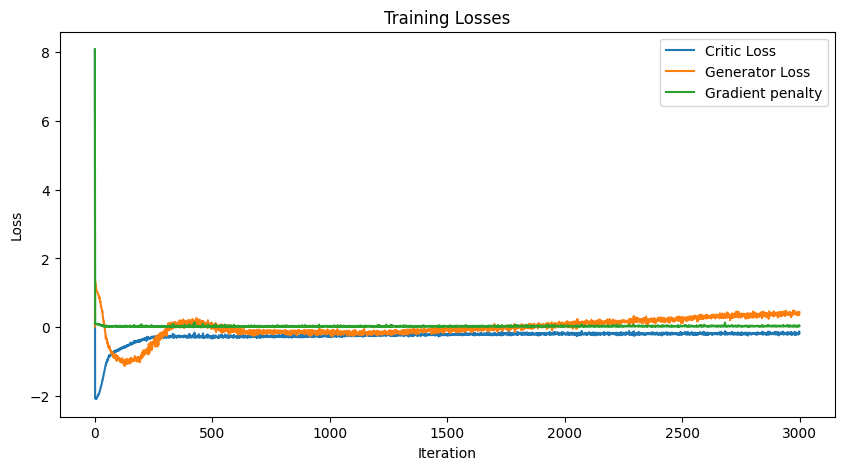

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(critic_losses, label='Critic Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.plot(gp_losses, label='Gradient penalty')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [55]:
# Assuming normalized_data is your full dataset as a numpy array
num_samples = 1000  # Number of samples to match the generated data

# Randomly select samples without replacement
indices = np.random.choice(normalized_data.shape[0], num_samples, replace=False)
real_data_samples = normalized_data[indices]

In [56]:
# Generate fake data for FID calculation
with torch.no_grad():
    noise = torch.randn(1000, input_dim, device=device)  # Sample 1000 noise vectors
    fake_data = generator(noise).cpu().numpy()  # Generate fake data and move to CPU

# Assuming real_data_samples is a numpy array of real data samples
# Calculate mean and covariance for fake and real data
mu_fake, sigma_fake = fake_data.mean(axis=0), np.cov(fake_data, rowvar=False)
mu_real, sigma_real = real_data_samples.mean(axis=0), np.cov(real_data_samples, rowvar=False)

# Calculate FID score
fid_score = calculate_fid(mu_fake, sigma_fake, mu_real, sigma_real)
print(f"FID score: {fid_score}")


FID score: 0.04109084792676523


In [57]:
normalized_data.shape

(13576, 37)

In [58]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
selected_columns = [9, 10, 11, 12, 15, 16]  # Specified features

# Convert the selected data to a pandas DataFrame for easier plotting
# You might want to name the columns based on your specific dataset
column_names = [numerical_cols[i] for i in selected_columns]

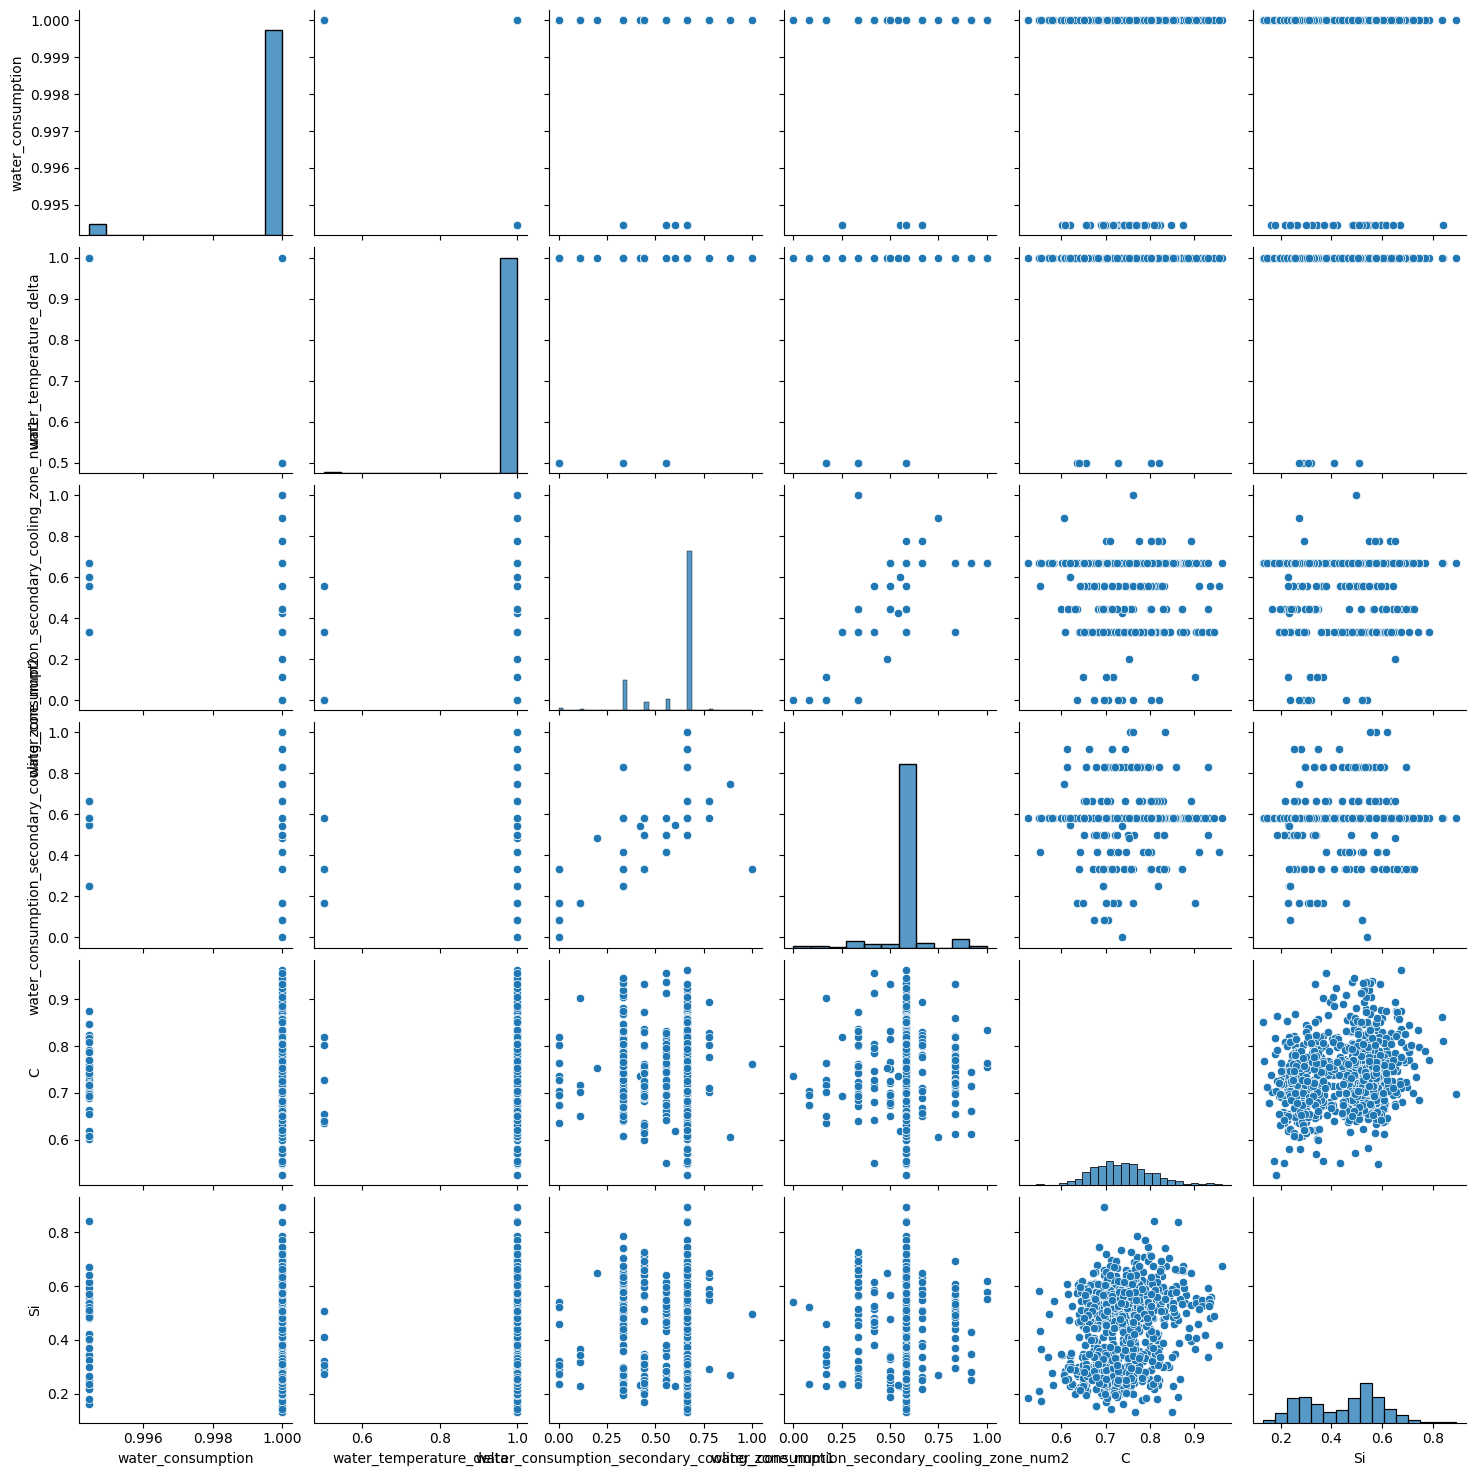

In [60]:
selected_data = real_data_samples[:, selected_columns]
# Assuming normalized_data is your numpy array and it has been normalized
# Convert the relevant slice of your numpy array to a DataFrame
# Select the first six columns/features for simplicity
df0 = pd.DataFrame(selected_data, columns=column_names)

# Create a pair plot
sns.pairplot(df0)

# Show the plot
plt.show()


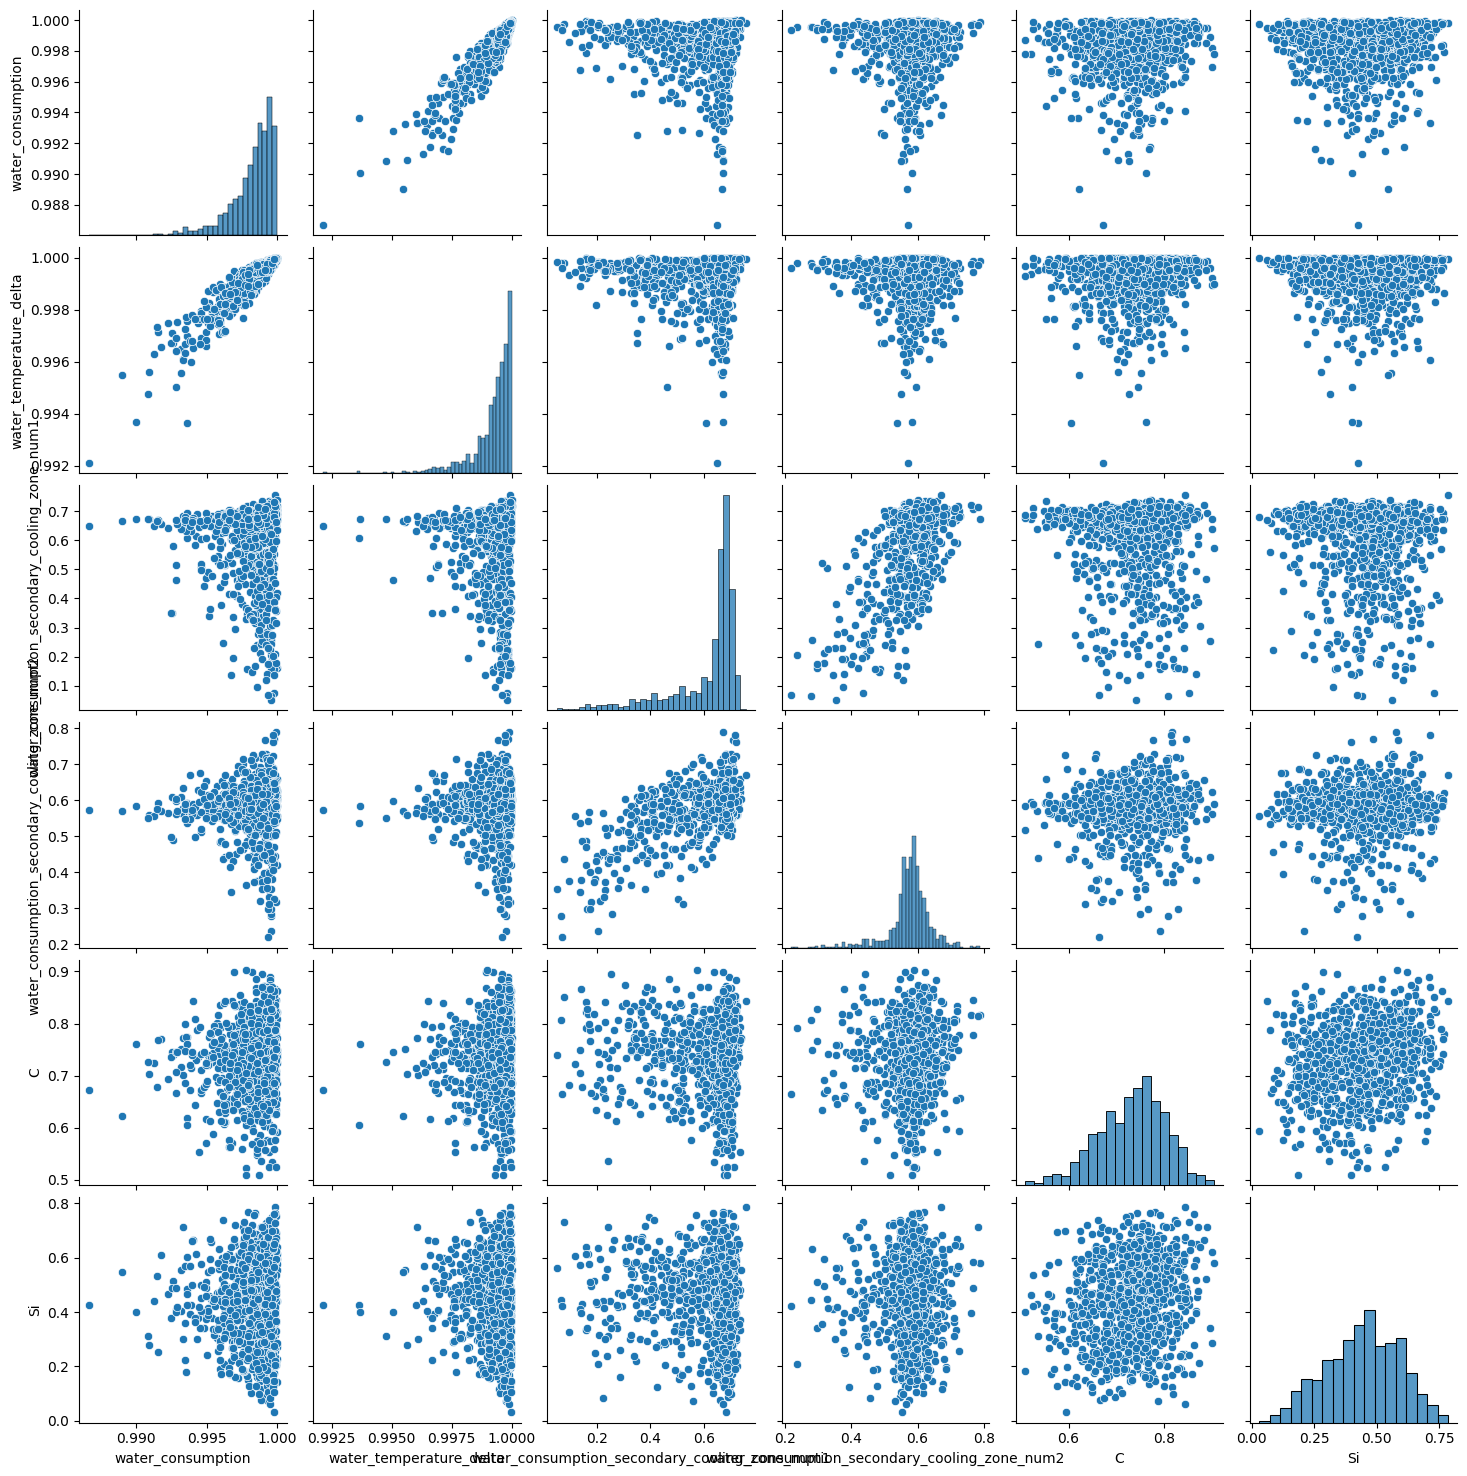

In [61]:
selected_data = fake_data[:, selected_columns]
# Assuming normalized_data is your numpy array and it has been normalized
# Convert the relevant slice of your numpy array to a DataFrame
# Select the first six columns/features for simplicity
df = pd.DataFrame(selected_data, columns=column_names)

# Create a pair plot
sns.pairplot(df)

# Show the plot
plt.show()

In [62]:
real_data_samples.shape

(1000, 37)

In [63]:
fake_data.shape

(1000, 37)

In [64]:
df0.shape, df.shape

((1000, 6), (1000, 6))

In [65]:
concatenated = pd.concat([df0.assign(dataset='real'), df.assign(dataset='generated')])

In [66]:
concatenated.columns

Index(['water_consumption', 'water_temperature_delta',
       'water_consumption_secondary_cooling_zone_num1',
       'water_consumption_secondary_cooling_zone_num2', 'C', 'Si', 'dataset'],
      dtype='object')

In [67]:
concatenated.columns = ['water_consumption', 'water_temperature_delta',
       'secondary_cooling_zone_1',
       'secondary_cooling_zone_2', 'C', 'Si', 'dataset']

In [68]:
sns.plotting_context()

{'font.size': 10.0,
 'axes.labelsize': 'medium',
 'axes.titlesize': 'large',
 'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium',
 'legend.fontsize': 'medium',
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

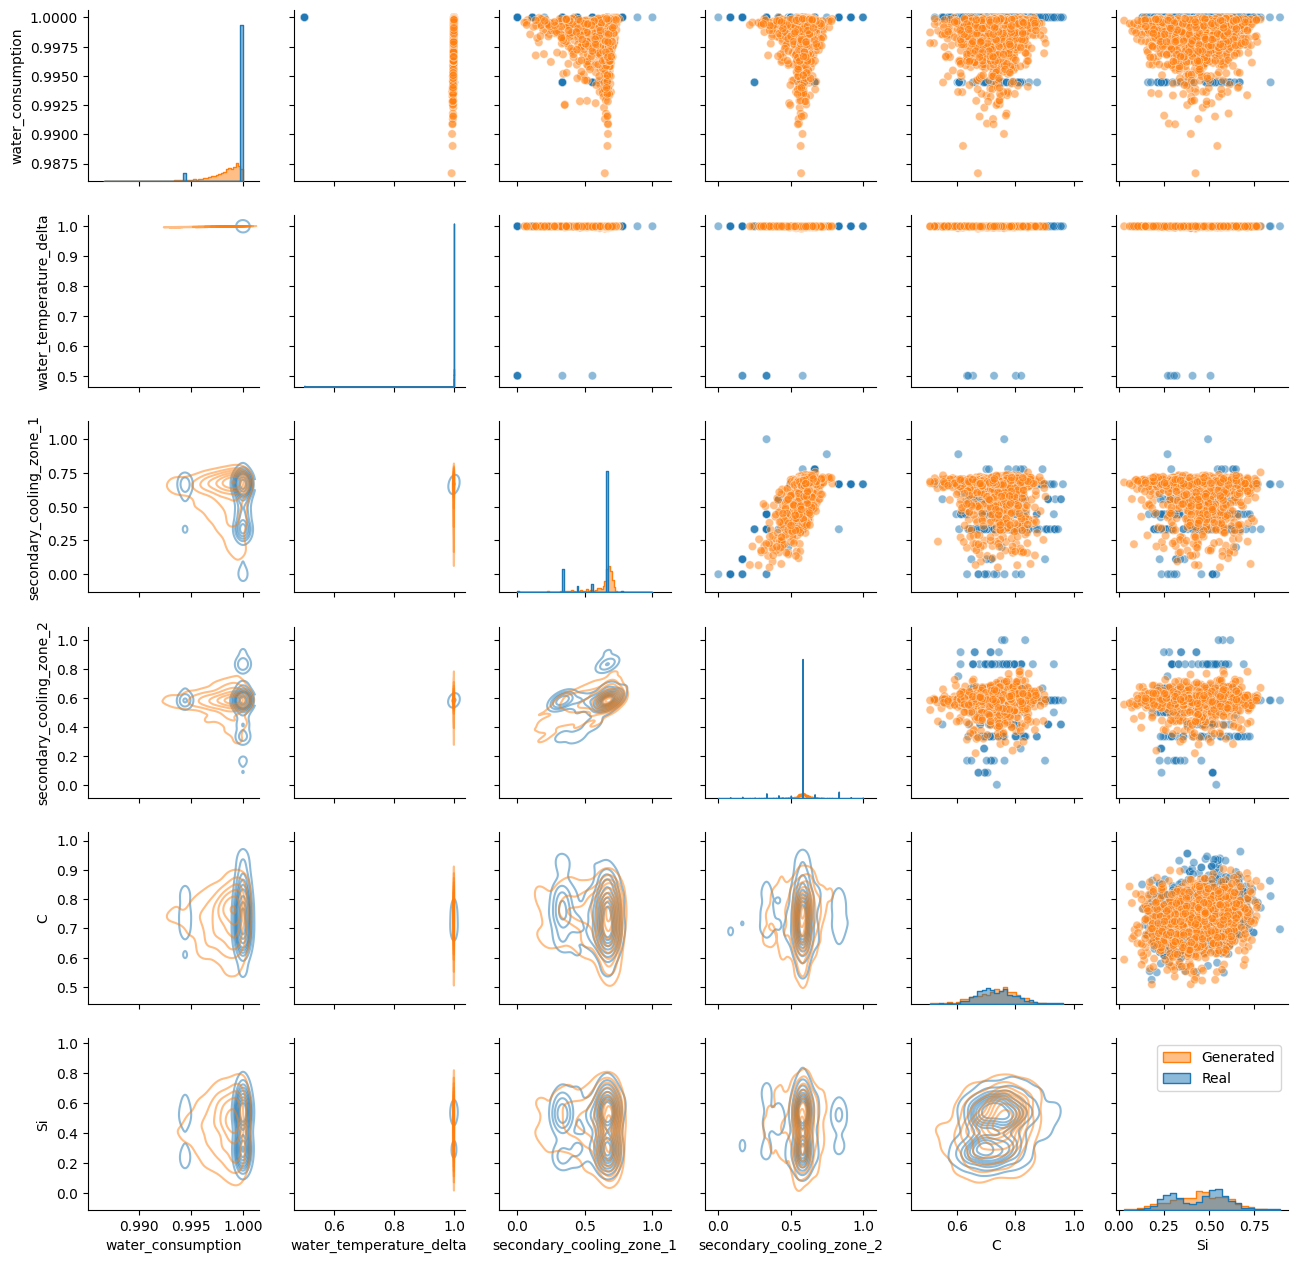

In [69]:
grid = sns.PairGrid(concatenated,  hue='dataset') # , palette='dark'

# Map the plots to the grid
# Diagonal plots (Histograms or KDE)
grid = grid.map_diag(sns.histplot,element="step", alpha=0.5, common_norm=False)

# Off-diagonal plots (Scatter plots)
# grid = grid.map_offdiag(sns.scatterplot, alpha=0.6)

grid = grid.map_upper(sns.scatterplot, alpha=0.5)
grid = grid.map_lower(sns.kdeplot,  alpha=0.5)

# Add legend
plt.legend(labels=['Generated', 'Real'])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

fig = plt.gcf()
fig.set_size_inches(15, 15)

plt.show()

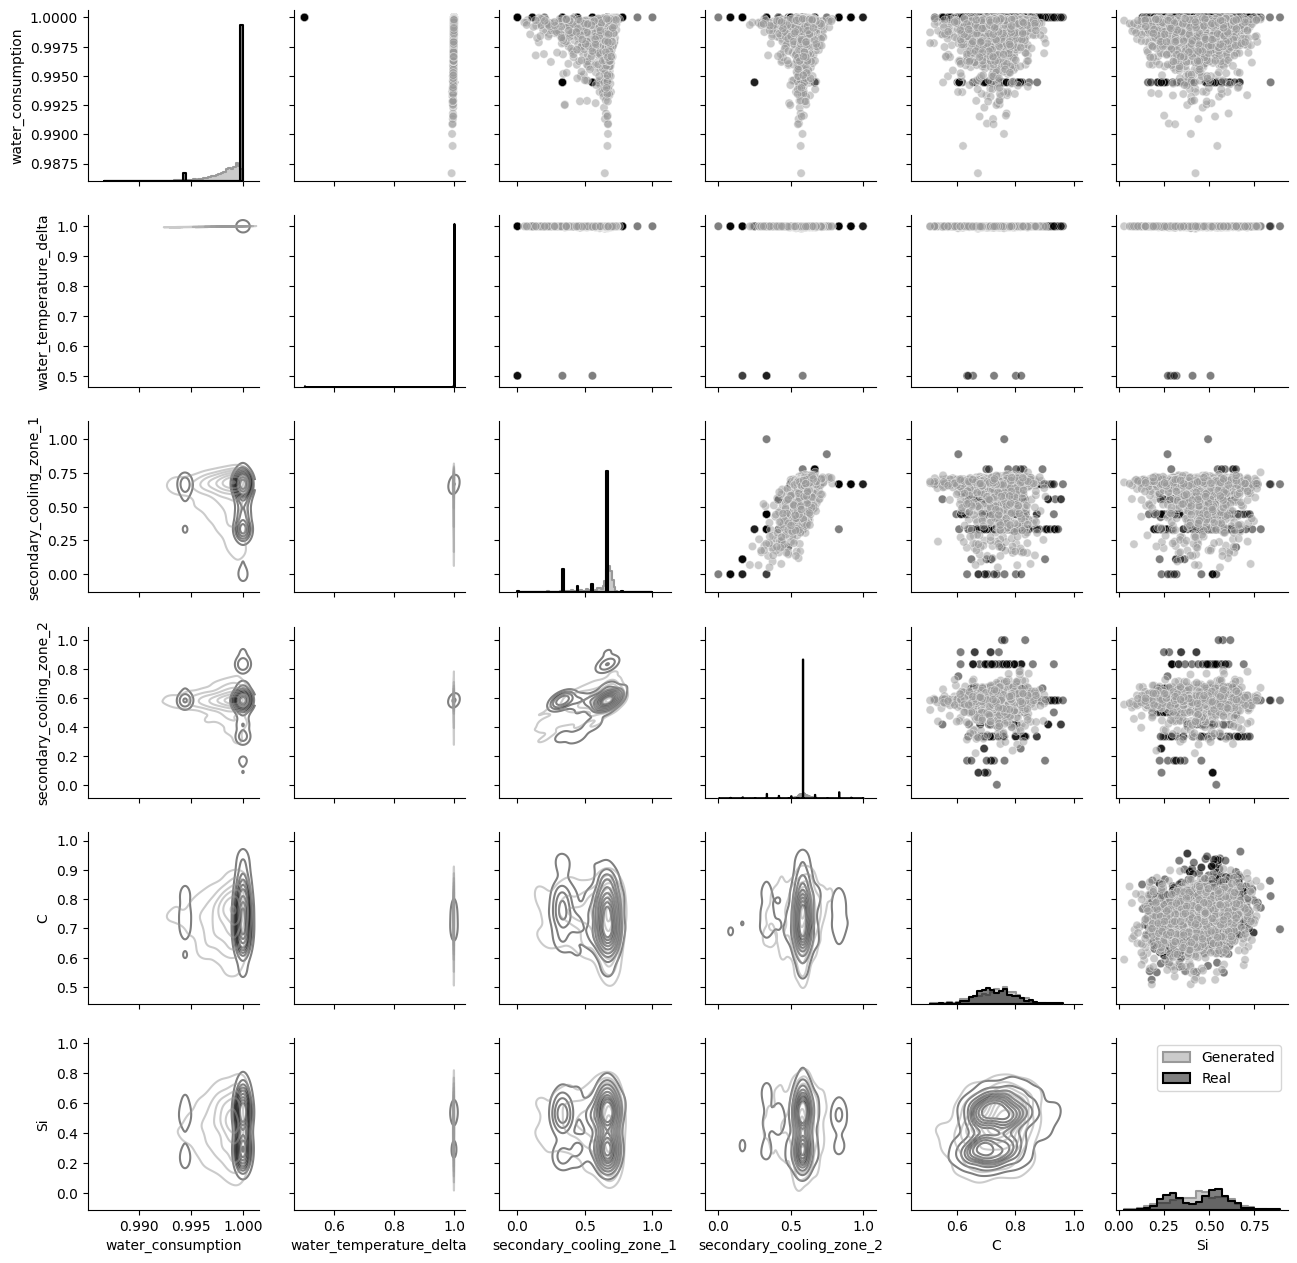

In [70]:
# Assuming 'concatenated' is your DataFrame with a 'dataset' column distinguishing 'Generated' and 'Real' data
grid = sns.PairGrid(concatenated, hue='dataset', palette=['black', '#999999'], hue_kws=dict(marker=["o", "s"]))

# Map the plots to the grid
# Diagonal plots (Histograms or KDE)
grid = grid.map_diag(sns.histplot, element="step", alpha=0.5, common_norm=False, linewidth=1.5)

# Off-diagonal plots
# Use scatterplot for the upper triangle with specified markers
grid = grid.map_upper(sns.scatterplot, alpha=0.5)

# Use kdeplot for the lower triangle, specifying line styles to differentiate between datasets
grid = grid.map_lower(sns.kdeplot, alpha=0.5, linewidths=1.5)

# Add legend
plt.legend(labels=['Generated', 'Real'])

# Adjust subplot parameters and set figure size for better layout and visibility
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
fig = plt.gcf()
fig.set_size_inches(15, 15)

plt.show()


In [71]:
range(6)

range(0, 6)

In [72]:
numerical_cols

Index(['workpiece_weight', 'cast_in_row', 'steel_weight_theoretical',
       'metal_residue_grab1', 'steel_weight', 'grab2_num',
       'swing_frequency_amount_minute', 'crystallizer_movement_mm',
       'alloy_speed_meter_minute', 'water_consumption',
       'water_temperature_delta',
       'water_consumption_secondary_cooling_zone_num1',
       'water_consumption_secondary_cooling_zone_num2',
       'temperature_measurement1', 'temperature_measurement2', 'C', 'Si', 'Mn',
       'S', 'P', 'Cr', 'Ni', 'Cu', 'As', 'Mo', 'Nb', 'Ti', 'V', 'Al', 'Ca',
       'N', 'Pb', 'Mg', 'Zn', 'num_crystallizer', 'num_stream', 'RUL'],
      dtype='object')